#가위바위보 분류기 : LeNet Model을 통한 이미지 분류기

1. 적절한 파라미터를 골라 트레이닝 수행
2. 과적합(overfitting)을 방지하기 위한 다양성있는 데이터 수집
3. test accuracy 60% 이상 목표

In [1]:
from PIL import Image
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras

##준비된 학습 데이터의 이미지 사이즈를 28 * 28로 변경하기 

- [teachable machine](https://teachablemachine.withgoogle.com/)에서 찍은 내 손 사진 300장
- [roboflow](https://public.roboflow.com/classification/rock-paper-scissors/1/download)에서 제공하는 Rock Paper Scissor Dataset(train용 이미지와 validation용 이미지 모두 train에 사용) 2,892장

**가위, 바위, 보 각 1,064장 총 3,192장**

In [2]:
def resize_images(img_path):
    images=glob.glob(img_path + "/*.jpg")  
    
    print(len(images), " images to be resized.")

    target_size=(28,28)
    for img in images:
        old_img=Image.open(img)
        new_img=old_img.resize(target_size,Image.ANTIALIAS)
        new_img.save(img, "JPEG")
    
    print(len(images), " images resized.")

    
# 가위
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/scissor"
resize_images(image_dir_path)
# 바위
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/rock"
resize_images(image_dir_path)
# 보
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/paper"
resize_images(image_dir_path)

1064  images to be resized.
1064  images resized.
1064  images to be resized.
1064  images resized.
1064  images to be resized.
1064  images resized.


##학습 데이터에 준비된 이미지 넣기

**모델을 훈련 시킬 때 입력값을 0~1 사이 값으로 적절하게 정규화 시키기 위해, 학습 데이터의 픽셀 값이 최대 얼마인지 확인해야 함.**

In [3]:
def load_data(img_path, number_of_data=3192): 
    img_size=28
    color=3

    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissor/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    
        labels[idx]=0   
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img 
        labels[idx]=1 
        idx=idx+1  
    
    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img  
        labels[idx]=2  
        idx=idx+1
        
    print("학습데이터(x_train)의 이미지 개수는", idx,"입니다.")
    return imgs, labels

image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper"
(x_train, y_train)=load_data(image_dir_path)

학습데이터(x_train)의 이미지 개수는 3192 입니다.


In [4]:
print('학습데이터의 픽셀 값 최소값은 ', np.min(x_train), ', 최대값은 ', np.max(x_train))

학습데이터의 픽셀 값 최소값은  0 , 최대값은  255


In [5]:
x_train_norm = x_train/255.0    # 학습데이터 정규화

print("x_train shape: {}".format(x_train_norm.shape))
print("y_train shape: {}".format(y_train.shape))

x_train shape: (3192, 28, 28, 3)
y_train shape: (3192,)


라벨:  0


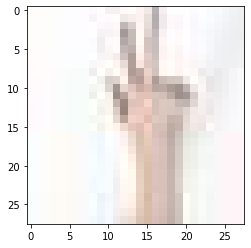

In [6]:
plt.imshow(x_train_norm[1000])
print('라벨: ', y_train[1000])

##딥러닝 네트워크 설계하기
- n_channel: 이미지의 특징을 고려하는 수(ex.손가락이 몇개면 '가위'로 분류하나?)
- n_dense: 분류할 이미지의 복잡도에 비례하는 수
- n_train_epoch: 모델이 학습을 진행할 횟수
 
**MNIST 숫자 손글씨 구분 모델 학습 진행 시 10번째까지 충분히 accuracy가 상승했다는 점과 학습횟수가 너무 높을 시 overfitting이 발생할 수 있음을 고려해 n_train epoch=5 로 파라미터 결정.**

In [16]:
n_channel_1 = 100
n_channel_2 = 100
n_dense = 100
n_train_epoch = 5


model = keras.models.Sequential()
model.add(keras.layers.Conv2D(n_channel_1, (3,3), activation = 'relu', input_shape = (28,28,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(n_channel_2, (3,3), activation = 'relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(n_dense, activation = 'relu'))
model.add(keras.layers.Dense(3, activation = 'softmax'))

print('Model에 추가된 Layer 개수: ', len(model.layers))

Model에 추가된 Layer 개수:  7


In [17]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 26, 26, 100)       2800      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 13, 13, 100)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 11, 11, 100)       90100     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 5, 5, 100)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 2500)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               250100    
_________________________________________________________________
dense_5 (Dense)              (None, 3)                

##딥러닝 네트워크 모델 학습시키기

**학습데이터는 (데이터갯수, 이미지 크기 x, 이미지 크기 y, 채널수) 형태로 입력되어야 함(x_train shape: (3192, 28, 28, 3)임을 확인함)**

In [18]:
model.compile(optimizer = 'adam',
             loss = 'sparse_categorical_crossentropy',
             metrics = ['accuracy'])
model.fit(x_train_norm, y_train, epochs = n_train_epoch)

Epoch 1/5
100/100 [==============================] - 1s 4ms/step - loss: 0.5762 - accuracy: 0.7497
Epoch 2/5
100/100 [==============================] - 0s 3ms/step - loss: 0.0786 - accuracy: 0.9815
Epoch 3/5
100/100 [==============================] - 0s 3ms/step - loss: 0.0237 - accuracy: 0.9966
Epoch 4/5
100/100 [==============================] - 0s 3ms/step - loss: 0.0070 - accuracy: 0.9997
Epoch 5/5
100/100 [==============================] - 0s 3ms/step - loss: 0.0040 - accuracy: 0.9994


##테스트 데이터 불러오기
- [roboflow](https://public.roboflow.com/classification/rock-paper-scissors/1/download)에서 제공하는 Rock Paper Scissor Dataset(test) 33장

**학습용 데이터와 같은 방법으로 불러오고, 정규화**

In [19]:
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test/t_scissor"
resize_images(image_dir_path)
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test/t_rock"
resize_images(image_dir_path)
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test/t_paper"
resize_images(image_dir_path)

def load_data(img_path, number_of_data=33): 
    img_size=28
    color=3

    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/t_scissor/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    
        labels[idx]=0   
        idx=idx+1

    for file in glob.iglob(img_path+'/t_rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img 
        labels[idx]=1 
        idx=idx+1  
    
    for file in glob.iglob(img_path+'/t_paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img  
        labels[idx]=2  
        idx=idx+1
        
    print("테스트데이터(x_test)의 이미지 개수는", idx,"입니다.")
    return imgs, labels

image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test"
(x_test, y_test)=load_data(image_dir_path)

print('테스트데이터의 픽셀 값 최소값은 ', np.min(x_test), ', 최대값은 ', np.max(x_test))

11  images to be resized.
11  images resized.
11  images to be resized.
11  images resized.
11  images to be resized.
11  images resized.
테스트데이터(x_test)의 이미지 개수는 33 입니다.
테스트데이터의 픽셀 값 최소값은  0 , 최대값은  255


In [20]:
x_test_norm = x_test/255.0  

print("x_test shape: {}".format(x_test_norm.shape))
print("y_test shape: {}".format(y_test.shape))

x_test shape: (33, 28, 28, 3)
y_test shape: (33,)


##테스트 데이터로 성능 확인하기

In [22]:
test_loss, test_accuracy = model.evaluate(x_test_norm, y_test, verbose = 2)
print("test_lose: {}".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))

2/2 - 0s - loss: 0.0353 - accuracy: 1.0000
test_lose: 0.035277657210826874
test_accuracy: 1.0


###회고

- 처음 학습 데이터를 만들 때, 내 손 이미지 300장만으로 모델을 학습시킨 탓에 overfitting이 심하게 발생했음(accuracy 6%대...)
- 프리소스 이미지를 구한 것은 다행이나, 많은 양의 데이터를 파일 경로에 업로드하는 과정이 너무 느려 직접 업로드하지 않고 zip 파일로 묶은 다음 cloud shell에서 unzip 명령을 반복적으로 내리는 데에서 시간 소요가 컸음.

* accuracy를 높이기 위해 시도한 것들: 학습 데이터 양을 늘리고 파라미터(n_channel_1, n_channel_2, n_dense, n_train epoch)를 조절했음.

* 알게 된 점: 학습 데이터는 가능한 많이, 다양하게. 특히 이번 손 모양처럼, 사람에 따라 그 모양이 아주 다양할 수 있는 데이터는 한사람이 만든 것으로는 한계가 크다..! 반드시 여러 사람의 샘플이 필요.

* 궁금한 점1: 입력 데이터는 분명 이미지 파일인데, 정규화 과정이 단순 최대 픽셀 수 나누기 연산으로 시행되는 원리가 뭘까? 

* 궁금한 점2: model.compile() 과정은 무슨 뜻일까?

* 모호한 점1: n_channel_1, n_channel_2, n_dense의 의미는 구체적으로 어떤 것일까? n_train_epoch는 지나치게 높을 경우 overfitting이 일어난다는 점이 이해되지만 n_channel_1, n_channel_2, n_dense는 비용적인 부분에서 한계가 없다면 늘리면 늘릴 수록 좋은 걸까?

* 모호한 점2: 어차피 데이터를 0~1 픽셀의 작은 크기로 정규화할 것이라면 이미지 사이즈를 28 * 28이 아니라 더 작은 크기로 변경했어야 하는 게 아닐까?


* 다짐: 학습 데이터는 많이, 다양하게.